In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import keras.backend.tensorflow_backend as KTF

Using TensorFlow backend.


In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')
#uploader = files.upload()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
my_path = '/content/gdrive/My Drive/cleaned_data.zip (Unzipped Files)/drive-download-20181211t234626z-001.zip (Unzipped Files)'
train_bounding_box = np.load(my_path + '/train_data.npy')
training_image = np.load('/content/gdrive/My Drive/train_imgs.npy')
train_class = train_bounding_box[:,4]

#load augmented data
aug_images = np.load('/content/gdrive/My Drive/augmented_image.npy')
aug_class = np.zeros((aug_images.shape[0],))
aug_box = np.load('/content/gdrive/My Drive/augmented_boxes.npy')


#convert 
stacked_training_box = np.vstack((train_bounding_box[:,:4],aug_box))
train_x = np.reshape(np.sum((stacked_training_box[:,0] , .5 * stacked_training_box[:,3]),axis=0),(-1,1))
train_y = np.reshape(np.sum((stacked_training_box[:,1] , .5 * stacked_training_box[:,2]),axis=0),(-1,1))
train_bounding_box = np.hstack((train_x,train_y,stacked_training_box[:,2:]))
train_class = np.concatenate((train_class,aug_class),axis=0)
training_image = np.vstack((training_image,aug_images))


In [0]:
# -*- coding:utf-8 -*-
'''  
#====#====#====#====
# Originally implemented by DuFanXin and modified by Ken Hayashima 
# Original implementation is found at https://github.com/DuFanXin/U-net/blob/master/Unet/unet-Keras.py
#====#====#====#==== 
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Flatten, Dense, Softmax,BatchNormalization,Activation
from keras.models import *
from keras.optimizers import *
import keras.backend as K
import tensorflow as tf
class myUnet(object):
    def __init__(self, img_rows=256, img_cols=256):
        self.img_rows = img_rows
        self.img_cols = img_cols

    def get_body(self,pretrained_weights=None):
        inputs = Input((256, 256, 3),name = 'input')
        #contracring path
        conv1 = Conv2D(16, 3, padding='same', kernel_initializer='he_normal',name='conv1_1')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation='relu')(conv1)
        print(inputs.shape)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        conv2 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal',name='conv2_1')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation='relu')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        conv3 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal',name='conv3_1')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation='relu')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        conv4 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal',name='conv4_1')(pool3)
        conv4 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal',name='conv4_2')(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation='relu')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        conv5 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal',name='conv5_1')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation='relu')(conv5)
        drop5 = Dropout(0.5)(conv5)
        #expanding path
        up6 = Conv2D(128, 2, padding='same', kernel_initializer='he_normal',name='up6')(UpSampling2D(size=(2, 2))(drop5))
        up6 = BatchNormalization()(up6)
        up6 = Activation(activation='relu')(up6)
        merge6 = concatenate([drop4, up6], axis=3)
        conv6 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal',name='conv6_1')(merge6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation(activation='relu')(conv6)
        up7 = Conv2D(64, 2, padding='same', kernel_initializer='he_normal',name='up7')( UpSampling2D(size=(2, 2))(conv6))
        up7 = BatchNormalization()(up7)
        up7 = Activation(activation='relu')(up7)
        merge7 = concatenate([conv3, up7], axis=3)
        conv7 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal',name='conv7_1')(merge7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation(activation='relu')(conv7)
        up8 = Conv2D(32, 2, padding='same', kernel_initializer='he_normal',name='up8')( UpSampling2D(size=(2, 2))(conv7))
        up8 = BatchNormalization()(up8)
        up8 = Activation(activation='relu')(up8)
        merge8 = concatenate([conv2, up8], axis=3) 
        conv8 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal',name='conv8_1')(merge8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation(activation='relu')(conv8)
        up9 = Conv2D(16, 2, padding='same', kernel_initializer='he_normal',name='up9')( UpSampling2D(size=(2, 2))(conv8))
        up9 = BatchNormalization()(up9)
        up9 = Activation(activation='relu')(up9)
        merge9 = concatenate([conv1, up9], axis=3)
        conv9 = Conv2D(16, 3, padding='same', kernel_initializer='he_normal',name='conv9_1')(merge9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation='relu')(conv9)
        conv9 = Conv2D(2, 3, padding='same', kernel_initializer='he_normal',name='conv9_3')(conv9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation='relu')(conv9)
        dense1 = Flatten()(conv9)
        out_box = Dense(4,name='dense_box')(dense1)
        print(out_box.shape)
        model = Model(input=inputs,output=out_box)
        if pretrained_weights != None:
            model.load_weights(pretrained_weights)
        model.compile(optimizer=Adam(lr=1e-4), loss='mse', metrics=['accuracy'])
        print('model compile')
        return model
    def train(self,mode='already',img_paths = None,bounding_box_path = None,save_path=None,imgs_train_pre=None,imgs_mask_train_pre=None,pretrained_weights=None):
        print("loading data")
        if mode == 'already': 
            imgs_train,imgs_mask_train = imgs_train_pre,imgs_mask_train_pre
        else: 
            imgs_train, imgs_mask_train = load_training_data(save_path)
        print("loading data done")
        model = self.get_body(pretrained_weights)
        print("got unet") 
        model_checkpoint = ModelCheckpoint('./unet_10layers_bounding_box.hdf5', monitor='loss', verbose=1, save_best_only=True)
        early_call_back = EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')
        print('Fitting model...')
        history = model.fit(x=imgs_train, y=imgs_mask_train, validation_split=0.2, batch_size=32, epochs=100, verbose=1, shuffle=True, callbacks=[model_checkpoint])
        return history

In [0]:
unet_ten_layers_bb = myUnet()
history = unet_ten_layers_bb.train(imgs_train_pre=training_image / 255,imgs_mask_train_pre=train_bounding_box / 256)

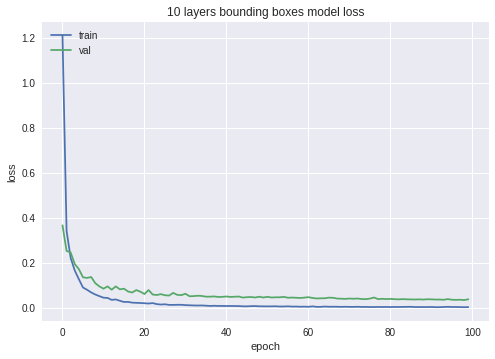

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('10 layers bounding boxes model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/content/gdrive/My Drive/10_layers_bounding_boxes_model_loss.png')

In [0]:
#assuming (x,y,w,h) for each
def iou(train,test):
  #compute intersection corner
  intersect_left_x = np.asarray(np.maximum(train[:,0],test[:,0]))
  intersect_left_y = np.asarray(np.maximum(train[:,1],test[:,1]))
  intersect_right_x = np.asarray(np.minimum(np.sum((train[:,0],train[:,3]),axis=0),np.sum((test[:,0],test[:,3]),axis=0)))
  intersect_right_y = np.asarray(np.minimum(np.sum((train[:,1],train[:,2]),axis=0),np.sum((test[:,1],test[:,2]),axis=0)))
  intersect_width = np.subtract(intersect_right_x,intersect_left_x)
  intersect_width[intersect_width < 0] = 0
  intersect_height = np.subtract(intersect_right_y,intersect_left_y)
  intersect_height[intersect_height < 0] = 0
  #compute union corner
  train_area = np.multiply(train[:,2],train[:,3])
  test_area = np.multiply(test[:,2],test[:,3])
  intersect_area = np.multiply(intersect_width,intersect_height)
  print(intersect_area.shape)
  iou = np.divide(intersect_area , np.subtract(np.sum((train_area,test_area),axis=0),intersect_area))
  return iou


In [0]:
test_image = np.load('/content/gdrive/My Drive/copied_test_imgs.npy')
model = unet_ten_layers_bb.get_body(pretrained_weights = '/content/gdrive/My Drive/unet_10layers_bounding_box.hdf5')
prediction_on_test = model.predict(test_image/255)


(?, 256, 256, 16)
(?, 256, 256, 16)
(?, 128, 128, 16)


(?, 128, 128, 32)
(?, 64, 64, 32)


(?, 64, 64, 64)
(?, 32, 32, 64)


(?, 32, 32, 128)
(?, 16, 16, 128)


(?, 16, 16, 256)


(?, 32, 32, 128)
(?, 32, 32, 128)
merge: 
(?, 32, 32, 256)
(?, 4)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:154: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
test_label = np.load('/content/gdrive/My Drive/test_data.npy')
ground_truth_bounding_box_test = test_label[:,:4]

In [0]:
rescaled_prediction = prediction_on_test * 256
predicted_x = np.reshape(rescaled_prediction[:,0] - .5 * rescaled_prediction[:,3],(-1,1))
predicted_y = np.reshape(rescaled_prediction[:,1] - .5 * rescaled_prediction[:,2],(-1,1))
rescaled_prediction = np.hstack((predicted_x,predicted_y,rescaled_prediction[:,2:]))

(288,)


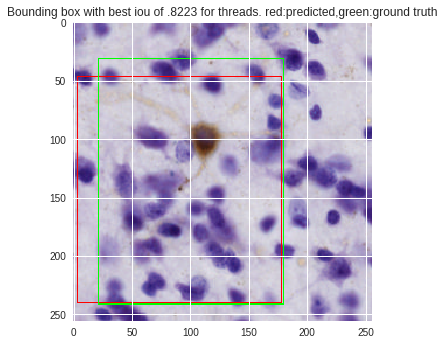

In [0]:
iou_measure = iou(rescaled_prediction,ground_truth_bounding_box_test)
best_image_index = np.argmax(iou_measure)
best_image = test_image[best_image_index,:,:,:]
cv2.rectangle(best_image,tuple(rescaled_prediction[best_image_index,:2]),(rescaled_prediction[best_image_index,0] + rescaled_prediction[best_image_index,3],rescaled_prediction[best_image_index,1] + rescaled_prediction[best_image_index,2]),(255,0,0),1)
cv2.rectangle(best_image,tuple(ground_truth_bounding_box_test[best_image_index,:2]),(ground_truth_bounding_box_test[best_image_index,0] + ground_truth_bounding_box_test[best_image_index,3],ground_truth_bounding_box_test[best_image_index,1] + ground_truth_bounding_box_test[best_image_index,2]),(0,255,0),1)
plt.title('Bounding box with best iou of .8294 for threads. red:predicted,green:ground truth')
plt.imshow(best_image[:,:,:].astype('uint8'))

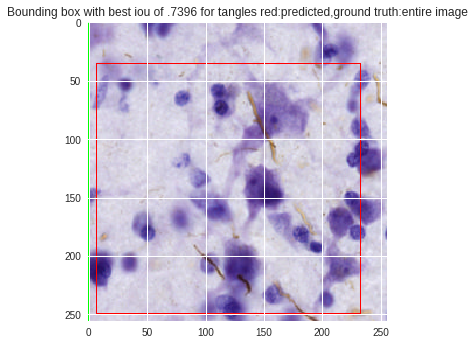

In [0]:
best_tangle_index = np.argmax(iou_measure[test_label[:,4] == 0])
tangle_images = test_image[test_label[:,4] == 0]
best_tangle_image = tangle_images[best_tangle_index,:,:,:]
tangle_rescaled_prediction = rescaled_prediction[test_label[:,4] == 0]
tangle_ground_truth_bounding_box_test = ground_truth_bounding_box_test[test_label[:,4] == 0]
cv2.rectangle(best_tangle_image,tuple(tangle_rescaled_prediction[best_tangle_index,:2]),(tangle_rescaled_prediction[best_tangle_index,0] + tangle_rescaled_prediction[best_tangle_index,3],tangle_rescaled_prediction[best_tangle_index,1] + tangle_rescaled_prediction[best_tangle_index,2]),(255,0,0),1)
cv2.rectangle(best_tangle_image,tuple(tangle_ground_truth_bounding_box_test[best_tangle_index,:2]),(tangle_ground_truth_bounding_box_test[best_tangle_index,0] + tangle_ground_truth_bounding_box_test[best_tangle_index,3],tangle_ground_truth_bounding_box_test[best_tangle_index,1] + tangle_ground_truth_bounding_box_test[best_tangle_index,2]),(0,255,0),1)
plt.title('Bounding box with best iou of .7396 for tangles red:predicted,ground truth:entire image')
plt.imshow(best_tangle_image[:,:,:].astype('uint8'))

In [0]:
#compare ious between two 
tangle_ious = iou_measure[test_label[:,4] == 0]
thread_ious = iou_measure[test_label[:,4] == 1]


Text(0.5,1,'tangle and thread ious')

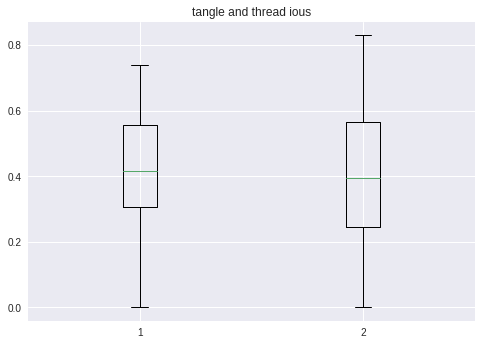

In [0]:
plt.boxplot([tangle_ious,thread_ious])
plt.title('tangle and thread ious')
